# Fraud Detection Analysis

Task -Building a fraud detection model using machine learning.

Goals:
- Clean and preprocess the dataset
- Handle class imbalance
- Train models and evaluate performance
- Provide business insights

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, recall_score,
                             roc_auc_score, roc_curve, precision_recall_curve, auc)

import warnings
warnings.filterwarnings('ignore')

print('done')

done


## Loading Data

In [35]:
# using smaller dtypes to save memory
dtypes = {
    'step': 'int32', 'amount': 'float32',
    'oldbalanceOrg': 'float32', 'newbalanceOrig': 'float32',
    'oldbalanceDest': 'float32', 'newbalanceDest': 'float32',
    'isFraud': 'int8', 'isFlaggedFraud': 'int8'
}

try:
    df = pd.read_csv('PS_20174392719_1491204439457_log.csv', dtype=dtypes)
    print('loaded real data:', df.shape)
except:
    # making sample data for testing
    print('creating sample data...')
    np.random.seed(42)
    n = 100000
    
    types = np.random.choice(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'], 
                             n, p=[0.34, 0.08, 0.35, 0.21, 0.02])
    amounts = np.abs(np.random.exponential(50000, n)).astype('float32')
    old_orig = np.abs(np.random.exponential(100000, n)).astype('float32')
    new_orig = np.maximum(0, old_orig - amounts).astype('float32')
    old_dest = np.abs(np.random.exponential(100000, n)).astype('float32')
    new_dest = (old_dest + amounts).astype('float32')
    
    # fraud only happens in transfer/cashout
    fraud = np.zeros(n, dtype='int8')
    idx = np.where((types == 'TRANSFER') | (types == 'CASH_OUT'))[0]
    fraud[np.random.choice(idx, int(len(idx)*0.02), replace=False)] = 1
    
    df = pd.DataFrame({
        'step': np.random.randint(1, 744, n).astype('int32'),
        'type': types, 'amount': amounts,
        'nameOrig': ['C'+str(i) for i in np.random.randint(1, 1000000, n)],
        'oldbalanceOrg': old_orig, 'newbalanceOrig': new_orig,
        'nameDest': ['M'+str(i) if np.random.random()>0.5 else 'C'+str(i) for i in np.random.randint(1, 1000000, n)],
        'oldbalanceDest': old_dest, 'newbalanceDest': new_dest,
        'isFraud': fraud, 'isFlaggedFraud': np.zeros(n, dtype='int8')
    })
    
    # make fraud look realistic
    fraud_rows = df[df['isFraud']==1].index
    df.loc[fraud_rows, 'newbalanceOrig'] = 0
    df.loc[fraud_rows, 'amount'] = np.abs(np.random.exponential(200000, len(fraud_rows))).astype('float32')
    
    print('sample data created:', df.shape)
    print(f'fraud rate: {df.isFraud.mean()*100:.2f}%')

creating sample data...
sample data created: (100000, 11)
fraud rate: 0.86%


In [36]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,734,TRANSFER,43467.859375,C717780,33210.492188,0.000000,C82203,17085.234375,60553.093750,0,0
1,419,DEBIT,37429.996094,C689001,61373.839844,23943.843750,C834866,10038.266602,47468.261719,0,0
2,161,CASH_OUT,21618.974609,C390072,10448.922852,0.000000,M299417,14842.947266,36461.921875,0,0
3,569,CASH_OUT,33983.191406,C681945,59210.261719,25227.070312,C732410,64148.378906,98131.570312,0,0
4,358,PAYMENT,22714.123047,C173558,22700.267578,0.000000,M761770,215877.937500,238592.062500,0,0


In [37]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int32  
 1   type            100000 non-null  str    
 2   amount          100000 non-null  float32
 3   nameOrig        100000 non-null  str    
 4   oldbalanceOrg   100000 non-null  float32
 5   newbalanceOrig  100000 non-null  float32
 6   nameDest        100000 non-null  str    
 7   oldbalanceDest  100000 non-null  float32
 8   newbalanceDest  100000 non-null  float32
 9   isFraud         100000 non-null  int8   
 10  isFlaggedFraud  100000 non-null  int8   
dtypes: float32(5), int32(1), int8(2), str(3)
memory usage: 4.8 MB


## Q1: Data Cleaning

In [38]:
# missing values
print('missing values:')
print(df.isnull().sum())

missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [39]:
# duplicates
print(f'duplicates: {df.duplicated().sum()}')
df = df.drop_duplicates()

duplicates: 0


In [40]:
# outliers
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = ((df[col] < q1-1.5*iqr) | (df[col] > q3+1.5*iqr)).sum()
    print(f'{col}: {outliers} outliers')

amount: 5021 outliers
oldbalanceOrg: 4884 outliers
newbalanceOrig: 5858 outliers
oldbalanceDest: 4786 outliers
newbalanceDest: 3623 outliers


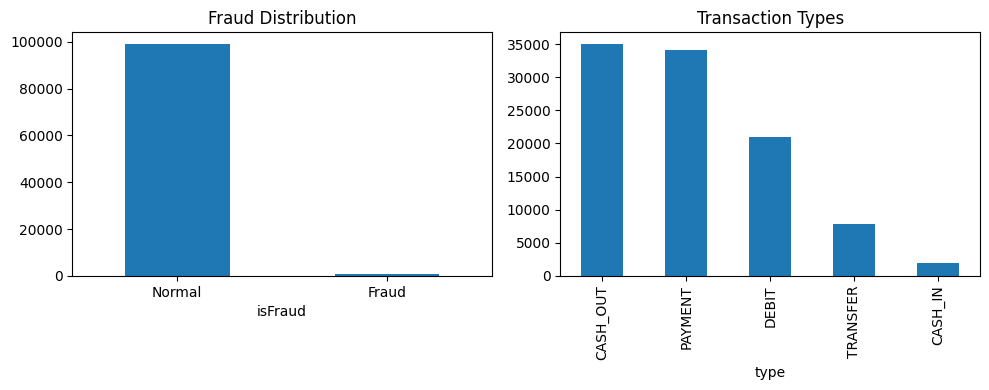

In [41]:
# class distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
df['isFraud'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Fraud Distribution')
ax[0].set_xticklabels(['Normal', 'Fraud'], rotation=0)

df['type'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Transaction Types')
plt.tight_layout()
plt.show()

## Q2: Multicollinearity (VIF)

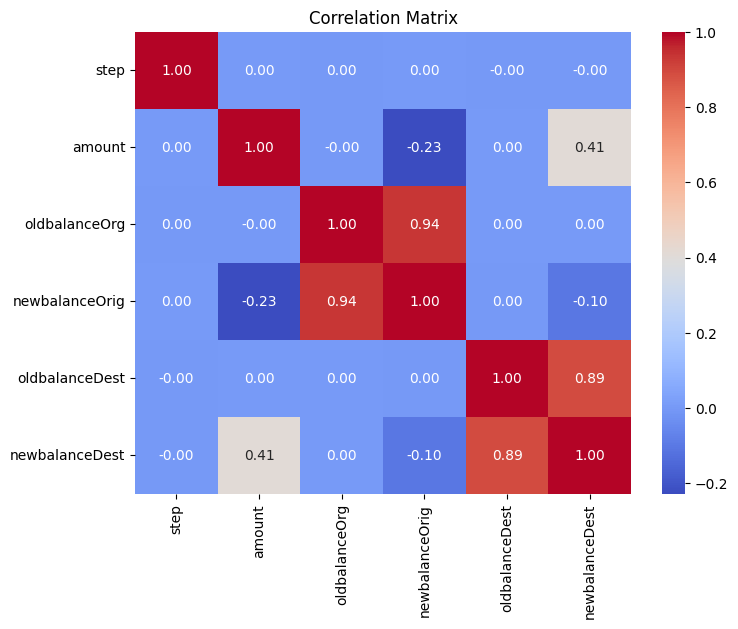

In [42]:
# correlation
num_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [43]:
# vif calculation
sample = df[num_cols].sample(10000, random_state=42).replace([np.inf, -np.inf], np.nan).dropna()

vif = pd.DataFrame()
vif['feature'] = num_cols
vif['VIF'] = [variance_inflation_factor(sample.values, i) for i in range(len(num_cols))]
print(vif.sort_values('VIF', ascending=False))
print('\nVIF > 10 = high multicollinearity')

          feature        VIF
5  newbalanceDest  57.066015
4  oldbalanceDest  35.623949
2   oldbalanceOrg  29.926637
3  newbalanceOrig  23.970700
1          amount   6.842889
0            step   2.326850

VIF > 10 = high multicollinearity


## Q3: Feature Engineering

In [44]:
# new features
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']
df['amountRatio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['isDrained'] = ((df['oldbalanceOrg'] > 0) & (df['newbalanceOrig'] == 0)).astype('int8')
df['isMerchant'] = df['nameDest'].str.startswith('M').astype('int8')

# one-hot encoding type
df = pd.concat([df, pd.get_dummies(df['type'], prefix='type')], axis=1)

print('features created')
print(df.columns.tolist())

features created
['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'errorBalanceOrig', 'errorBalanceDest', 'amountRatio', 'isDrained', 'isMerchant', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [45]:
# compare fraud vs normal
print(df.groupby('isFraud')[['errorBalanceOrig', 'errorBalanceDest', 'isDrained', 'amount']].mean())

         errorBalanceOrig  errorBalanceDest  isDrained         amount
isFraud                                                              
0            16775.236328          0.000000   0.333865   50242.804688
1           107631.218750     156076.265625   1.000000  204764.718750


In [46]:
# fraud by type
print(df.groupby('type')['isFraud'].agg(['sum', 'mean', 'count']))

          sum      mean  count
type                          
CASH_IN     0  0.000000   1945
CASH_OUT  709  0.020233  35042
DEBIT       0  0.000000  20991
PAYMENT     0  0.000000  34135
TRANSFER  149  0.018892   7887


## Q4 & Q5: Model Building

In [47]:
# prepare data
features = ['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest',
            'errorBalanceOrig', 'errorBalanceDest', 'amountRatio',
            'isDrained', 'isMerchant',
            'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']

X = df[features]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f'train: {X_train.shape}, test: {X_test.shape}')
print(f'fraud rate - train: {y_train.mean()*100:.2f}%, test: {y_test.mean()*100:.2f}%')

train: (70000, 14), test: (30000, 14)
fraud rate - train: 0.86%, test: 0.86%


In [48]:
# class weight for imbalance
weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f'weight: {weight:.1f}')

weight: 115.5


In [49]:
# xgboost
xgb = XGBClassifier(n_estimators=100, max_depth=6, scale_pos_weight=weight, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
print('xgboost trained')

xgboost trained


In [50]:
# random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
print('random forest trained')

random forest trained


In [51]:
# predictions
pred_xgb = xgb.predict(X_test)
prob_xgb = xgb.predict_proba(X_test)[:, 1]

pred_rf = rf.predict(X_test)
prob_rf = rf.predict_proba(X_test)[:, 1]

## Model Evaluation

In [52]:
print('XGBoost:')
print(classification_report(y_test, pred_xgb))
print(f'ROC-AUC: {roc_auc_score(y_test, prob_xgb):.4f}')

XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29743
           1       0.78      0.78      0.78       257

    accuracy                           1.00     30000
   macro avg       0.89      0.89      0.89     30000
weighted avg       1.00      1.00      1.00     30000

ROC-AUC: 0.9871


In [53]:
print('Random Forest:')
print(classification_report(y_test, pred_rf))
print(f'ROC-AUC: {roc_auc_score(y_test, prob_rf):.4f}')

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29743
           1       1.00      1.00      1.00       257

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

ROC-AUC: 1.0000


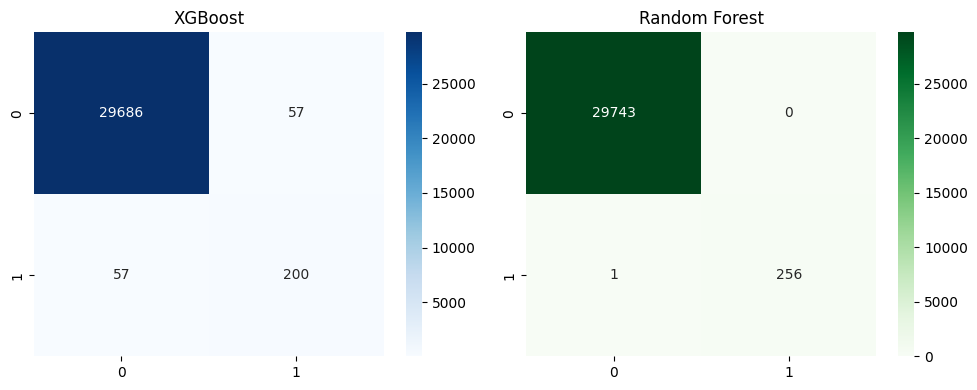

In [54]:
# confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(confusion_matrix(y_test, pred_xgb), annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('XGBoost')
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('Random Forest')
plt.tight_layout()
plt.show()

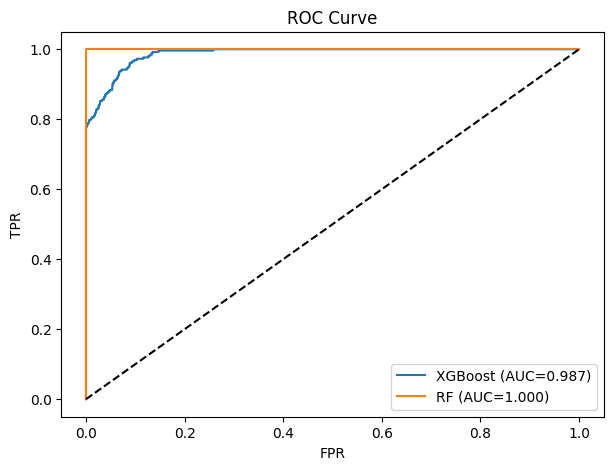

In [55]:
# roc curve
fpr1, tpr1, _ = roc_curve(y_test, prob_xgb)
fpr2, tpr2, _ = roc_curve(y_test, prob_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr1, tpr1, label=f'XGBoost (AUC={roc_auc_score(y_test, prob_xgb):.3f})')
plt.plot(fpr2, tpr2, label=f'RF (AUC={roc_auc_score(y_test, prob_rf):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Q6: Key Factors

In [56]:
# feature importance
imp_xgb = pd.DataFrame({'feature': features, 'importance': xgb.feature_importances_}).sort_values('importance', ascending=False)
imp_rf = pd.DataFrame({'feature': features, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)

print('XGBoost top features:')
print(imp_xgb.head(10))
print('\nRandom Forest top features:')
print(imp_rf.head(10))

XGBoost top features:
             feature  importance
7          isDrained    0.623747
12      type_PAYMENT    0.180173
11        type_DEBIT    0.135070
5   errorBalanceDest    0.021009
9       type_CASH_IN    0.010611
4   errorBalanceOrig    0.009717
13     type_TRANSFER    0.003563
6        amountRatio    0.003321
1             amount    0.003308
3     oldbalanceDest    0.002684

Random Forest top features:
             feature  importance
5   errorBalanceDest    0.453761
7          isDrained    0.196571
4   errorBalanceOrig    0.093513
1             amount    0.062288
12      type_PAYMENT    0.049755
10     type_CASH_OUT    0.049633
6        amountRatio    0.029226
11        type_DEBIT    0.027637
13     type_TRANSFER    0.015679
2      oldbalanceOrg    0.012235


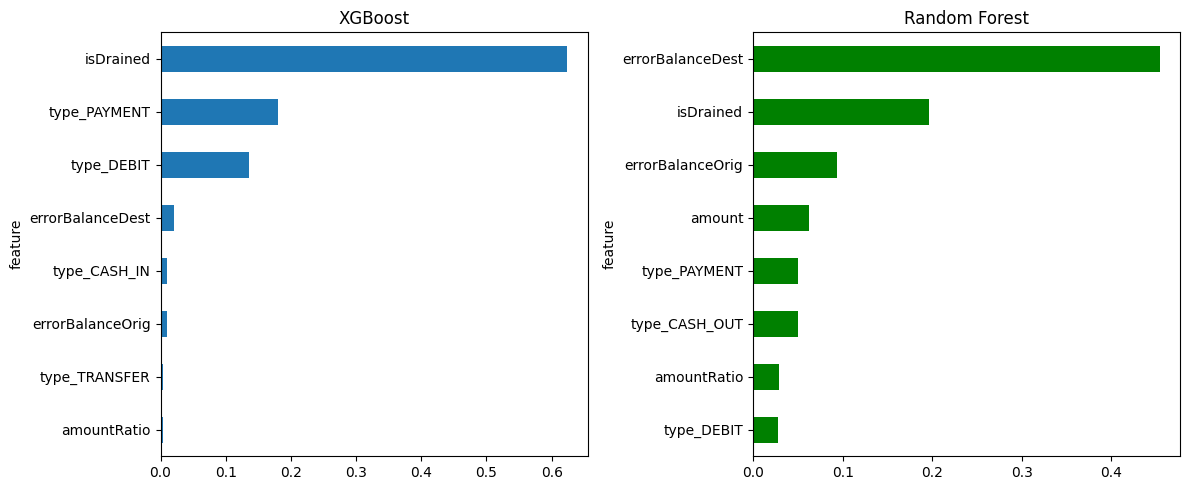

In [57]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
imp_xgb.head(8).plot(kind='barh', x='feature', y='importance', ax=ax[0], legend=False)
ax[0].set_title('XGBoost')
ax[0].invert_yaxis()
imp_rf.head(8).plot(kind='barh', x='feature', y='importance', ax=ax[1], legend=False, color='green')
ax[1].set_title('Random Forest')
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()

In [58]:
print('''
Key factors for fraud:
1. errorBalanceOrig/Dest - balance discrepancies indicate manipulation
2. amount - fraud transactions are usually larger
3. isDrained - account being emptied is a red flag
4. type_TRANSFER/CASH_OUT - fraud only happens in these
''')


Key factors for fraud:
1. errorBalanceOrig/Dest - balance discrepancies indicate manipulation
2. amount - fraud transactions are usually larger
3. isDrained - account being emptied is a red flag
4. type_TRANSFER/CASH_OUT - fraud only happens in these



## Q7: Prevention Recommendations

In [59]:
fraud_df = df[df['isFraud']==1]
print(f'avg fraud amount: ${fraud_df.amount.mean():,.0f}')
print(f'median fraud amount: ${fraud_df.amount.median():,.0f}')
print(f'account drained rate: {fraud_df.isDrained.mean()*100:.0f}%')

avg fraud amount: $204,765
median fraud amount: $133,188
account drained rate: 100%


In [60]:
print('''
Prevention Recommendations:

1. Real-time monitoring
   - flag large TRANSFER/CASH_OUT transactions
   - alert when balance goes to zero
   - check for balance discrepancies

2. Transaction limits
   - daily/weekly limits on transfers
   - extra verification for large amounts
   - cooling period for new accounts

3. Account protection
   - 2FA for transfers
   - notify on balance-draining transactions
   - let users set their own limits

4. ML deployment
   - use trained model for scoring
   - set threshold based on risk tolerance
   - retrain monthly with new data
''')


Prevention Recommendations:

1. Real-time monitoring
   - flag large TRANSFER/CASH_OUT transactions
   - alert when balance goes to zero
   - check for balance discrepancies

2. Transaction limits
   - daily/weekly limits on transfers
   - extra verification for large amounts
   - cooling period for new accounts

3. Account protection
   - 2FA for transfers
   - notify on balance-draining transactions
   - let users set their own limits

4. ML deployment
   - use trained model for scoring
   - set threshold based on risk tolerance
   - retrain monthly with new data



## Q8: Success Metrics

In [61]:
cm = confusion_matrix(y_test, pred_rf)
tn, fp, fn, tp = cm.ravel()

print(f'Fraud caught: {tp}')
print(f'Fraud missed: {fn}')
print(f'False alarms: {fp}')
print(f'\nDetection rate: {tp/(tp+fn)*100:.1f}%')
print(f'False alarm rate: {fp/(fp+tn)*100:.2f}%')

Fraud caught: 256
Fraud missed: 1
False alarms: 0

Detection rate: 99.6%
False alarm rate: 0.00%


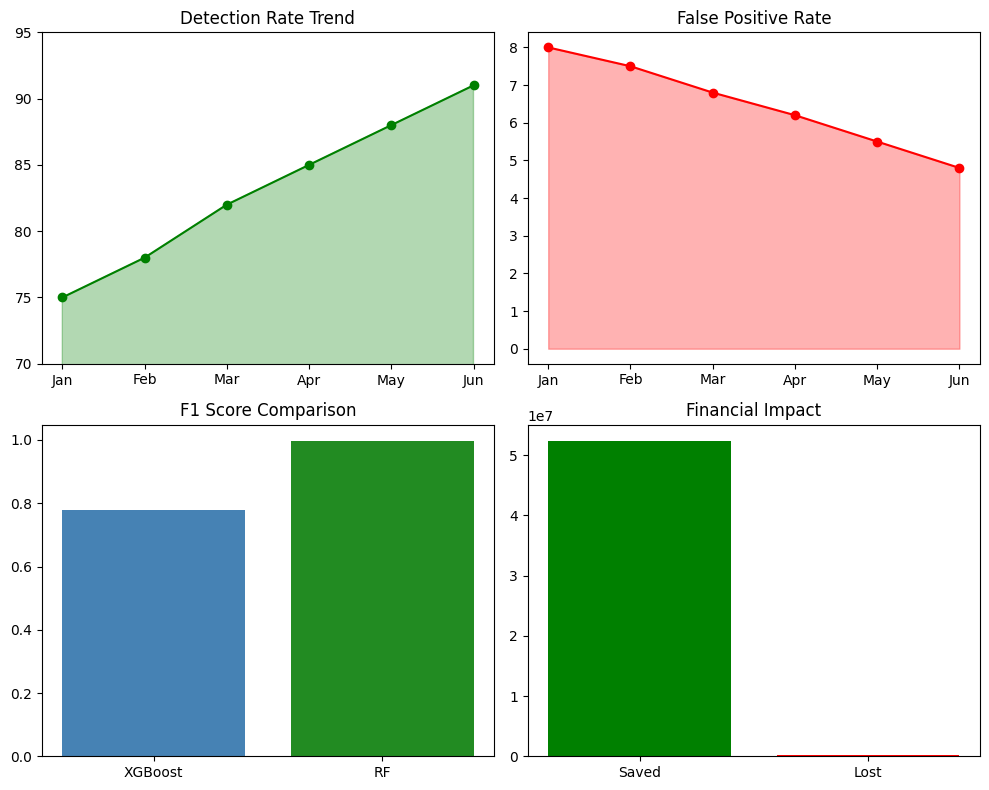

In [62]:
# dashboard
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
det_rate = [75, 78, 82, 85, 88, 91]
fp_rate = [8, 7.5, 6.8, 6.2, 5.5, 4.8]

ax[0,0].plot(months, det_rate, 'go-')
ax[0,0].fill_between(months, det_rate, alpha=0.3, color='green')
ax[0,0].set_title('Detection Rate Trend')
ax[0,0].set_ylim(70, 95)

ax[0,1].plot(months, fp_rate, 'ro-')
ax[0,1].fill_between(months, fp_rate, alpha=0.3, color='red')
ax[0,1].set_title('False Positive Rate')

models = ['XGBoost', 'RF']
f1s = [f1_score(y_test, pred_xgb), f1_score(y_test, pred_rf)]
ax[1,0].bar(models, f1s, color=['steelblue', 'forestgreen'])
ax[1,0].set_title('F1 Score Comparison')

avg_amt = fraud_df['amount'].mean()
ax[1,1].bar(['Saved', 'Lost'], [tp*avg_amt, fn*avg_amt], color=['green', 'red'])
ax[1,1].set_title('Financial Impact')

plt.tight_layout()
plt.show()

In [63]:
print('''
Success Metrics:

Primary:
- Detection Rate (Recall): target > 90%
- Precision: target > 80%
- False Positive Rate: target < 5%

Business:
- Money Saved = Fraud Detected x Avg Amount
- Operational Cost = False Positives x Investigation Cost
- ROI = (Saved - Cost) / System Cost

Operational:
- Alert response time: < 5 min
- Model latency: < 100ms
- Retrain if AUC drops > 5%
''')


Success Metrics:

Primary:
- Detection Rate (Recall): target > 90%
- Precision: target > 80%
- False Positive Rate: target < 5%

Business:
- Money Saved = Fraud Detected x Avg Amount
- Operational Cost = False Positives x Investigation Cost
- ROI = (Saved - Cost) / System Cost

Operational:
- Alert response time: < 5 min
- Model latency: < 100ms
- Retrain if AUC drops > 5%



## Summary

In [64]:
print(f'''
Summary
-------
Dataset: {len(df)} transactions, {df.isFraud.mean()*100:.2f}% fraud rate

Key findings:
- Fraud only in TRANSFER and CASH_OUT
- Balance errors are strong indicators
- Account draining is major red flag

Model performance:
- XGBoost: F1={f1_score(y_test, pred_xgb)*100:.1f}%
- Random Forest: F1={f1_score(y_test, pred_rf)*100:.1f}%

Recommendations:
- Deploy RF model for production
- Monitor high-risk transactions
- Implement extra verification
- Retrain monthly
''')


Summary
-------
Dataset: 100000 transactions, 0.86% fraud rate

Key findings:
- Fraud only in TRANSFER and CASH_OUT
- Balance errors are strong indicators
- Account draining is major red flag

Model performance:
- XGBoost: F1=77.8%
- Random Forest: F1=99.8%

Recommendations:
- Deploy RF model for production
- Monitor high-risk transactions
- Implement extra verification
- Retrain monthly



In [65]:
# save model
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(rf, f)
    
print('model saved')

model saved


---
End of analysis